<a href="https://colab.research.google.com/github/tcotte/CNN_Pytorch/blob/master/GradCam_CNNVisualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GradCam - Visualisation CNN

https://pypi.org/project/pytorch-gradcam/

In [47]:
pip install pytorch-gradcam

In [48]:
!git clone https://github.com/tcotte/CNN_Pytorch.git

fatal: destination path 'CNN_Pytorch' already exists and is not an empty directory.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [50]:
import warnings
warnings.filterwarnings("ignore")

## Infos
1. Using cats and dogs datasets (imageNet format)
2. Resnet50 model

## Load dataset

In [51]:
#classes = {0: 'Cat', 1: 'Dog'}

In [52]:
#reading the labels of data we uploaded
with open("/content/CNN_Pytorch/data/imagenet_labels.txt") as f:classes = eval(f.read())

In [53]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Load pretrained model

In [54]:
model = models.resnet50(pretrained=True)
#model =resnet.load_state_dict(torch.load("/content/CNN_Pytorch/resnet50_catsvsdogs.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Grad Cam analysis

In [55]:
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [56]:
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer4')
]

In [57]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

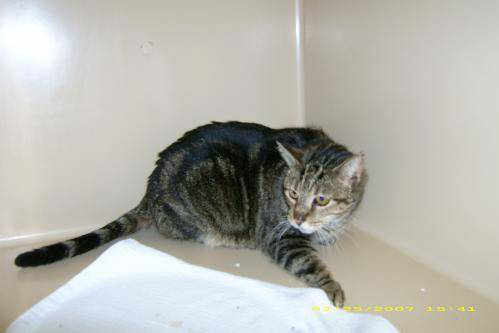

In [61]:
import os
import PIL

img_dir = '/content/CNN_Pytorch/data/CatVSDog/test/test'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_name = '12302.jpg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

In [62]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [63]:
 
#run the model on the images
outputs = model(normed_torch_img)

#get the maximum class 
_, pred = torch.max(outputs.data, 1)

print(pred, classes[pred.item()])

tensor([281], device='cuda:0') tabby, tabby cat


In [64]:
cam_images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    #cam_images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    cam_images.extend([torch_img.cpu(), heatmap_pp, result_pp])
    
grid_image = make_grid(cam_images, nrow=3)

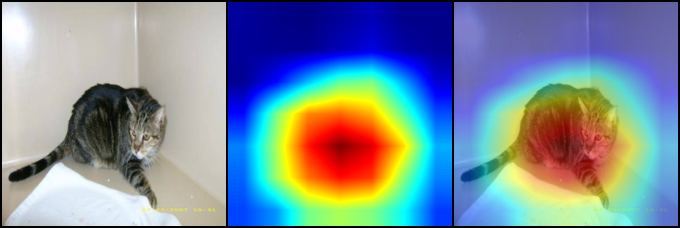

In [65]:
transforms.ToPILImage()(grid_image)